<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

# Предсказание оттока пользователей (весна 2021)

## Задача

Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

# Первая часть. Исследование

In [1]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


import lightgbm as lgb
from catboost import CatBoostClassifier

## Загрузка и подготовка данных (2 балла)

In [2]:
# для работы локально нужно выставить флаг local = True
# для чтения данных с с Google диска local = False
local = False

In [3]:
# чтение данных
if local:
    train = pd.read_csv('./train.csv')
    test =  pd.read_csv('./test.csv')
else:
    # чтение с Google диска
    
    #train
    url_train = "https://drive.google.com/file/d/1K-tf97Hjklw_eHFxeup36bBpElSC1hrb/view?usp=sharing"
    path_train = 'https://drive.google.com/uc?export=download&id='+ url_train.split('/')[-2]
    train = pd.read_csv(path_train)

    #test
    url_test = "https://drive.google.com/file/d/1ZDlKZdX0arZLQfqu9qNy7Oh2BvdeE_1Z/view?usp=sharing"
    path_trest = 'https://drive.google.com/uc?export=download&id='+ url_test.split('/')[-2]
    test = pd.read_csv(path_trest)


In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Смотрим на данные.

In [5]:
train.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
test.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

**Вывод**: Пропусков в данных нет.

## Преобразование типов данных

Посмотрим количества уникальных **unique** значений различных признаков строкового типа. 

In [9]:
train.describe(include=[np.object])

,TotalSpent,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,4978,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,20.2,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,9,2655,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786


Все признаки кроме TotalSpent переведем в категориальный тип. А TotalSpent в тип float64.

Смотрим на данные числового типа.

In [10]:
train.describe(include=[np.number])

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


SeniorCitizen переведем в категориальный тип.

In [11]:
# SeniorCitizen -> category
train['IsSeniorCitizen'] = train['IsSeniorCitizen'].astype('category')
test['IsSeniorCitizen'] = test['IsSeniorCitizen'].astype('category')

В строковом типе TotalSpent пропуски заменим на '0.0' и преобразуем в float64

In [12]:
train['TotalSpent'] = train['TotalSpent'].replace(' ','0.0')
train['TotalSpent'] = train['TotalSpent'].astype('float64')

test['TotalSpent'] = test['TotalSpent'].replace(' ','0.0')
test['TotalSpent'] = test['TotalSpent'].astype('float64')

Все строковые переводим в категориальные.

In [13]:
# строковые типы переводим в категориальные
list_object_columns = list(train.dtypes[train.dtypes == object].index)

for col in list_object_columns:
    train[col] = train[col].astype('category')    
    test[col] = test[col].astype('category') 

Смотрим результат.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              5282 non-null   int64   
 1   MonthlySpending           5282 non-null   float64 
 2   TotalSpent                5282 non-null   float64 
 3   Sex                       5282 non-null   category
 4   IsSeniorCitizen           5282 non-null   category
 5   HasPartner                5282 non-null   category
 6   HasChild                  5282 non-null   category
 7   HasPhoneService           5282 non-null   category
 8   HasMultiplePhoneNumbers   5282 non-null   category
 9   HasInternetService        5282 non-null   category
 10  HasOnlineSecurityService  5282 non-null   category
 11  HasOnlineBackup           5282 non-null   category
 12  HasDeviceProtection       5282 non-null   category
 13  HasTechSupportAccess      5282 non-null   catego

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              1761 non-null   int64   
 1   MonthlySpending           1761 non-null   float64 
 2   TotalSpent                1761 non-null   float64 
 3   Sex                       1761 non-null   category
 4   IsSeniorCitizen           1761 non-null   category
 5   HasPartner                1761 non-null   category
 6   HasChild                  1761 non-null   category
 7   HasPhoneService           1761 non-null   category
 8   HasMultiplePhoneNumbers   1761 non-null   category
 9   HasInternetService        1761 non-null   category
 10  HasOnlineSecurityService  1761 non-null   category
 11  HasOnlineBackup           1761 non-null   category
 12  HasDeviceProtection       1761 non-null   category
 13  HasTechSupportAccess      1761 non-null   catego

**Вывод:** Данные загружены и подготовлены к проведению EDA.

## EDA Анализ данных (3 балла)

### Рассмотрим датасет на наличие дисбаланса классов.

''

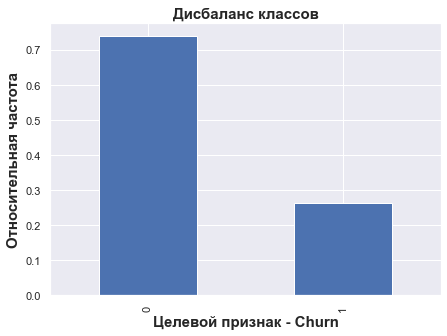

In [16]:
sns.set(rc={'figure.figsize':(7, 5)})
class_frequency = train['Churn'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.xlabel('Целевой признак - Churn',fontsize=15, weight = 'bold')
plt.ylabel('Относительная частота',fontsize=15, weight = 'bold')
plt.title("Дисбаланс классов",fontsize=15, weight = 'bold')
;

In [17]:
print(class_frequency)

0    0.737978
1    0.262022
Name: Churn, dtype: float64


In [18]:
class_frequency[0]/class_frequency[1]

2.816473988439306

**Вывод: Мы имеем выраженный дисбаланс классов в отношении 0 класса к 1 классу, как 3:1. Для повышения качетсва метрики при обучении моделей этот факт необходимо будет учесть.**

### Распределение численных признаков

#### MonthlySpending

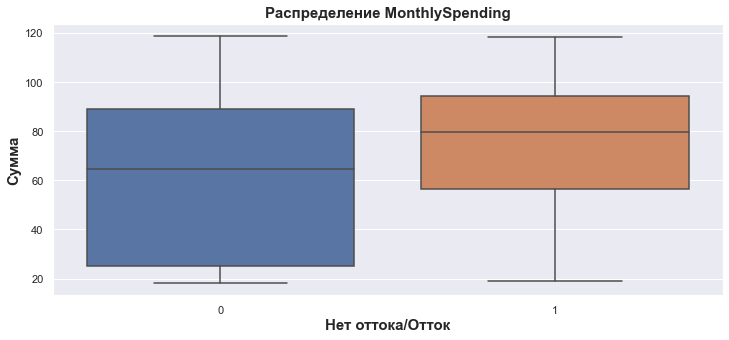

In [19]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Churn', y = 'MonthlySpending', data=train);
plt.title("Распределение MonthlySpending", fontsize=15, weight = 'bold')
plt.ylabel('Сумма',fontsize=15, weight = 'bold')
plt.xlabel('Нет оттока/Отток',fontsize=15, weight = 'bold');

**Вывод:** Чем больше ежемесячные платежи, тем больше отток.

#### TotalSpent

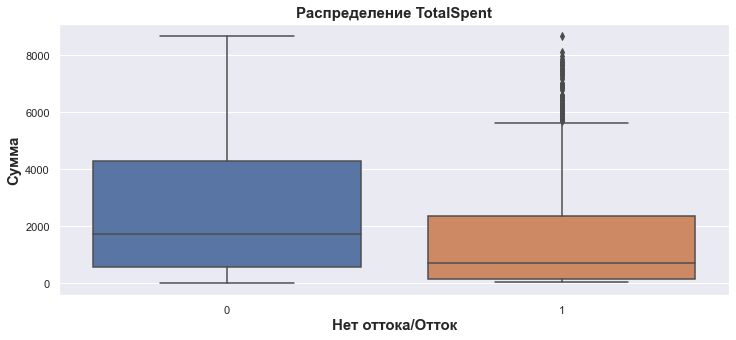

In [20]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Churn', y = 'TotalSpent', data=train);
plt.title("Распределение TotalSpent", fontsize=15, weight = 'bold')
plt.ylabel('Сумма',fontsize=15, weight = 'bold')
plt.xlabel('Нет оттока/Отток',fontsize=15, weight = 'bold');

**Вывод:** Общая сумма платежа не успевает повлиять на отток, клиент уходит раньше, чем выплатит всю сумму. По целевому признаку есть выбросы.

#### ClientPeriod

Text(0, 0.5, 'Количество')

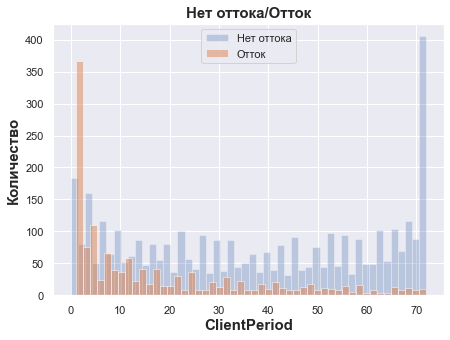

In [21]:
ax = train[train['Churn']==0]['ClientPeriod'].hist(bins=50, alpha=0.3)
train[train['Churn']==1]['ClientPeriod'].hist(bins=50, alpha=0.5)
ax.legend(['Нет оттока', 'Отток'])

plt.title("Нет оттока/Отток",fontsize=15, weight = 'bold');
plt.xlabel('ClientPeriod', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')

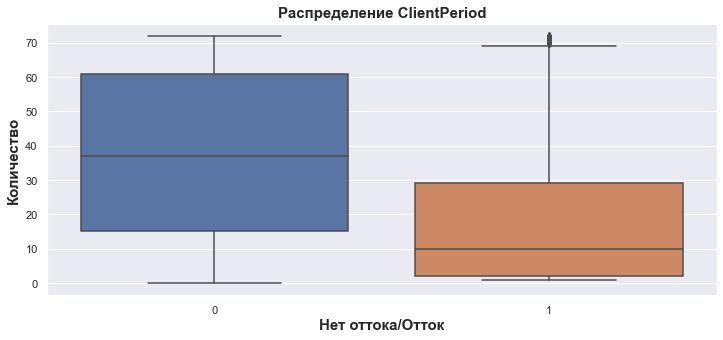

In [22]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Churn', y = 'ClientPeriod', data=train);
plt.title("Распределение ClientPeriod", fontsize=15, weight = 'bold')
plt.ylabel('Количество',fontsize=15, weight = 'bold')
plt.xlabel('Нет оттока/Отток',fontsize=15, weight = 'bold');

**Вывод:** Чем меньше срок взаимодействия клиента и кампании тем больше отток. По целевому признаку на трэйне есть выбросы.

Все три признака вместе:

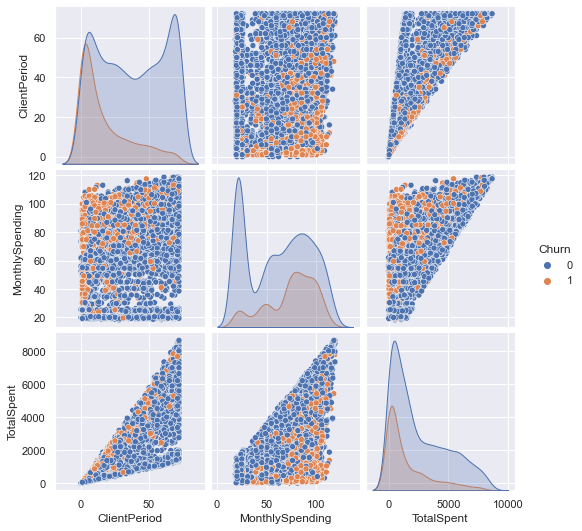

In [23]:
sns.pairplot(train[num_cols + [target_col]], hue=target_col);

Вывод: Подозрительно хорошо коррелируют пары (ClientPeriod, TotalSpent) и (MonthlySpending, TotalSpent)

#### Проверка на мультиколлинеарность признаков

Для числовых переменных можно построить матрицу корреляции Пирсона.

In [24]:
train[['ClientPeriod','MonthlySpending', 'TotalSpent']].corr()

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.000000,0.249414,0.826658
MonthlySpending,0.249414,1.000000,0.652014
TotalSpent,0.826658,0.652014,1.000000


 **Корреляция между TotalSpent и ClientPeriod равна 0.82, также между TotalSpent и MonthlySpending корреляция пирсона равна 0.65. Всё это может негативно сказаться на моделях. Перед обучением модели нужно будет удалить потенциально опасный признак TotalSpent.**

### Относительные частоты категориальных признаков

In [25]:
def category_value_count(data):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for i, col in enumerate(cat_cols):
        axs[i // 4][i % 4].pie(
            data[col].value_counts(normalize=True),
            labels=data[col].value_counts().index,
            autopct='%1.1f%%'
        )
        axs[i // 4][i % 4].set_title(col)

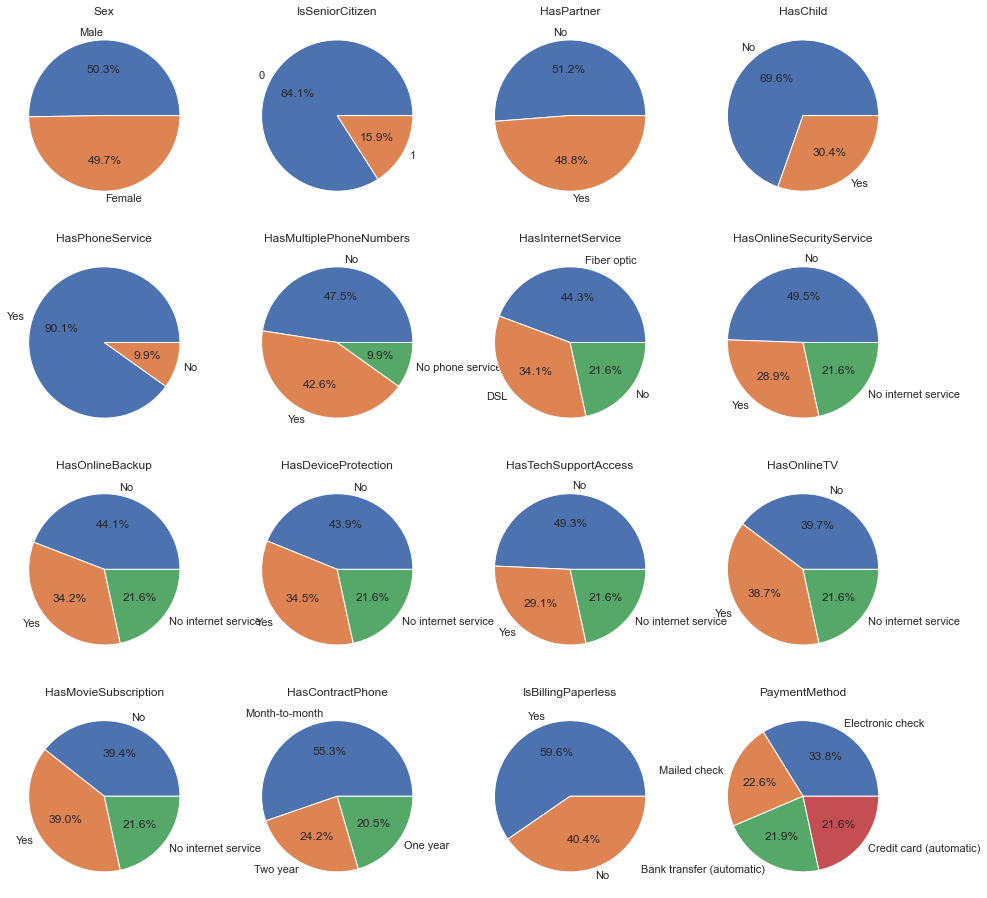

In [26]:
category_value_count(train)

### Влияние различных значений категориальных признаков на отток (распределение целевой переменной по признакам)

In [27]:
def plot_hist_groups(data, cols, n_cols, title='сервис'):

    fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize = (15,4))
    for i, col in enumerate(cols):

        ax[i].hist(data[data['Churn'] == 0][col], ec='black', alpha=0.42)
        ax[i].hist(data[data['Churn'] == 1][col], ec='black', alpha=0.84)
        ax[i].set_title(f"{title} {col}")
        ax[i].legend(['Нет оттока', 'Отток'])

    plt.ylabel('Количество')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

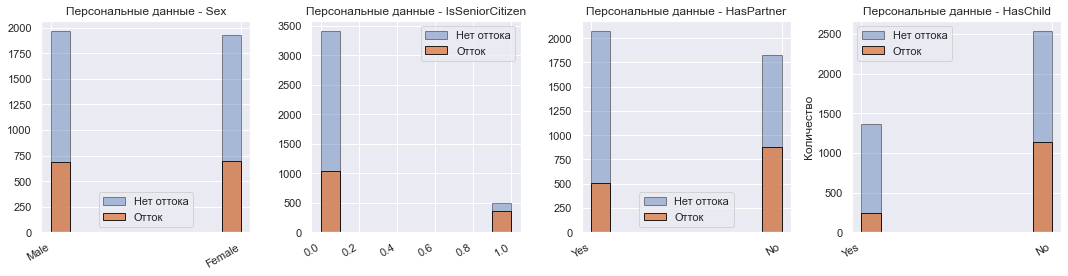

In [28]:
cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild']
plot_hist_groups(train, cols, 4, 'Персональные данные -')

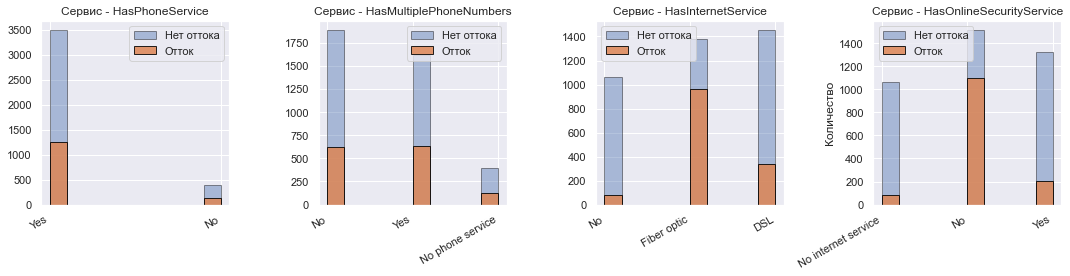

In [29]:
cols = ['HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService']
plot_hist_groups(train, cols, 4, 'Сервис -')

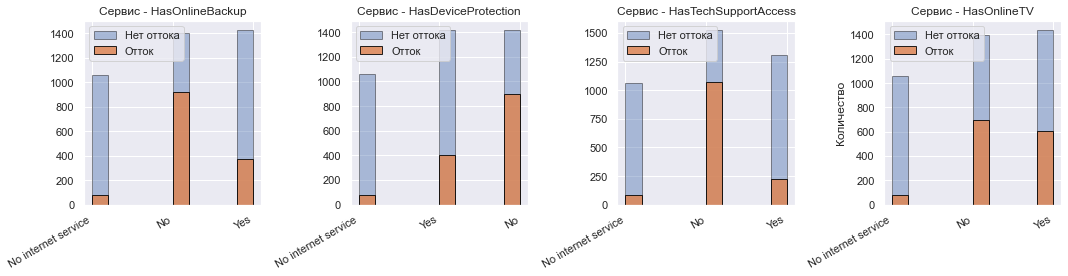

In [30]:
cols = ['HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV']
plot_hist_groups(train, cols, 4, 'Сервис -')

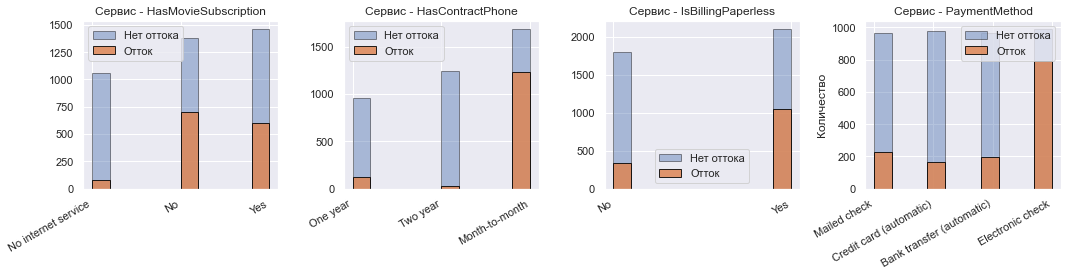

In [31]:
cols = ['HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
plot_hist_groups(train, cols, 4, 'Сервис -')

**Выводы:**

Не влияют на отток следующие признаки:
- Sex, HasMultiplePhoneNumbers, HasOnlineTV, HasMovieSubscription

Влияют на отток:

- PaymentMethod (видим отток при значении Electronic check)
- HasContractPhone (видим отток при значении Month-to-month )
- HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasOnlineSecurityService, HasInternetService, HasInternetService (видим отток при неподключении сервиса, значение - No) 

#### Нелинейный зависимости

Нелинейные зависимости попробуем выявить через Phik (𝜙k)

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

Данный критерий работает с любыми типами переменных, включая категориальные. И основан на критерии Хи-квадрат.

Цитирую документацию:

"Phi_K is a new and practical correlation coefficient based on several refinements to Pearson’s hypothesis test of independence of two variables.

The combined features of Phi_K form an advantage over existing coefficients. First, it works consistently between categorical, ordinal and interval variables. Second, it captures non-linear dependency. Third, it reverts to the Pearson correlation coefficient in case of a bi-variate normal input distribution. These are useful features when studying the correlation matrix of variables with mixed types.

.........

The calculation of correlation coefficients between paired data variables is a standard tool of analysis for every data analyst. Pearson’s correlation coefficient is a de facto standard in most fields, but by construction only works for interval variables (sometimes called continuous variables). Pearson is unsuitable for data sets with mixed variable types, e.g. where some variables are ordinal or categorical".

In [32]:
# Библиотека для анализа нелинейных зависимостей

#!pip3 install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [33]:
phik_overview = train.phik_matrix()
phik_overview.round(2)
phik_overview['Churn'].sort_values(ascending=False).to_frame().style.background_gradient()

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Churn']


,Churn
Churn,1.000000
ClientPeriod,0.469423
PaymentMethod,0.442566
MonthlySpending,0.360202
IsBillingPaperless,0.298737
TotalSpent,0.277363
HasChild,0.252610
HasContractPhone,0.250575
IsSeniorCitizen,0.242130
HasPartner,0.229302


**Вывод: Наиболее значимыми и влияющими на отток признаками будут - ClientPeriod, PaymentMethod, MonthlySpending и IsBillingPaperless**

Данный факт можно будет проверить по значению feature_importance для бустинговых моделей.

## Применение линейных моделей (3 балла)

<!-- 1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.) -->

In [34]:
# собирать данные о моделях будем в список
result_list = []

Убираем TotalSpent для исключения ошибок связанных с коллиенарностью.

In [35]:
num_cols = ['ClientPeriod', 'MonthlySpending','TotalSpent']   

df_train = train.copy()
if 'TotalSpent' in df_train.columns:
    del df_train['TotalSpent']
    num_cols = ['ClientPeriod', 'MonthlySpending']

Ранее мы выяснили, что на тестовой выборке есть выбросы по признаку ClientPeriod. Этот признак имеет большую важность при обучении.Уберем эти выбросы, так как они негативно скажуться на линейной модели.

In [36]:
# функция очищает датасет от выбросов, отбрасывая объекты за пределами межквартильного размаха

def frame_irq(df, column_list=[], query=False, koeff=1.5):
    if len(column_list)==0:
        column_list = list(df.columns)
    for column in column_list:
        q25 = df[column].quantile(0.25)                 
        q75 = df[column].quantile(0.75) 
        minimum = df[column].min()
        maximum = df[column].max()    
        irq = np.abs(q75 - q25)    
        left = q25 - koeff*irq
        right = q75 + koeff*irq
        if query: 
            sql_sentence='@left <= '+ column + ' and '+ column + ' <= @right'
            df = df.query(sql_sentence)
        else:
            df_tmp = df[(df[column]>left)&(df[column]<right)]
            if len(df_tmp) != 0:
                df=df_tmp.copy()
        pass
    return df

In [37]:
frames=[frame_irq(df_train.query('Churn==1'),['ClientPeriod']),df_train.query('Churn==0')]
df_train_irq15 = pd.concat(frames)
df_train_irq15.shape

(5264, 19)

In [38]:
df_train.shape

(5282, 19)

In [39]:
X = df_train_irq15.drop('Churn', axis=1)
y = df_train_irq15['Churn']

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split ( 
                                X, y, test_size=0.25, random_state=42)

Создаем Pipeline для орбработки категориальных признаков для логистической регрессии. 

In [41]:
# pipeline для LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)]) 

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, class_weight = 'balanced'))])



Ищем лучшие параметры на сетке

In [42]:
grid = {"classifier__C": [100, 10, 1, 0.1, 0.01, 0.001], #Inverse of regularization strength
        "classifier__penalty":['l2'],
        "preprocessor__cat__drop":['first']
        } 
gcv = GridSearchCV(pipe, grid, cv=5, scoring='roc_auc', refit=True)
grid_result = gcv.fit(X_train, y_train)

In [43]:
print('best params:', grid_result.best_params_)
print('best score:', grid_result.best_score_)

best params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'preprocessor__cat__drop': 'first'}
best score: 0.8489599760767522


In [44]:
lg_best_estimator = gcv.best_estimator_

In [45]:
y_pred = lg_best_estimator.predict_proba(X_valid)[:, 1]
y_bin = (y_pred >= 0.5)*1

In [46]:
def plot_ROC(y_valid, y_pred, model=''):

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-'+ model)

    plt.show()

In [47]:
auc = roc_auc_score(y_valid, y_pred)
print("AUC:", auc)
print("")
print(classification_report(y_valid, y_bin))

AUC: 0.8486374586184224

              precision    recall  f1-score   support

           0       0.92      0.72      0.80       949
           1       0.53      0.83      0.65       367

    accuracy                           0.75      1316
   macro avg       0.72      0.77      0.73      1316
weighted avg       0.81      0.75      0.76      1316



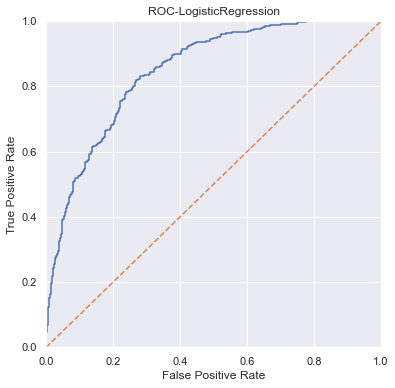

In [48]:
plot_ROC(y_valid, y_pred, 'LogisticRegression')

Запишем посылку для
соревнования на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) 

In [49]:
#test = pd.read_csv('./test.csv')
X_test = test.copy()
if 'TotalSpent' in X_test.columns:
    del X_test['TotalSpent']

submission = pd.read_csv('./submission.csv')
submission['Churn'] = lg_best_estimator.predict_proba(X_test)[:, 1] 
submission.to_csv('./my_submission_LogisticRegression.csv', index=False)

In [50]:
# добавляем данные по модели
result_list.append({ 'Model':'LogisticRegression','roc_auc_score':round(auc,5),'kaggle auc':float('0.84469')}) 
result_list    

[{'Model': 'LogisticRegression',
  'roc_auc_score': 0.84864,
  'kaggle auc': 0.84469}]

**Вывод** Для линейной модели LogisticRegression удалось достичь качества метрики на трайн выборке AUC = 0.84864

**kaggle AUC = 0.84469**

## Применение градиентного бустинга (2 балла)

<!-- Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать) -->

### CatBoostClassifier

Для catboost также возьмем сет очищенный от выбросов.

In [51]:
num_cols = ['ClientPeriod', 'MonthlySpending','TotalSpent']  

df_train = df_train_irq15.copy() #train.copy()

if 'TotalSpent' in df_train.columns:
    del df_train['TotalSpent']
    num_cols = ['ClientPeriod', 'MonthlySpending']
    
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']

CatBoostClassifier не требует технологии OHE для работы с категориальными данными. Достаточно просто указать категориальные колонки.

In [52]:
# получим список категориальных признаков
def get_category_features(df):
    category_cols = list(df.dtypes[df.dtypes == 'category'].index)
    cat_features_names = [col for col in df.columns if col in (category_cols)]
    cat_features = [df.columns.get_loc(col) for col in cat_features_names]
    return category_cols, cat_features_names, cat_features

cat_features,_,_ = get_category_features(X_train)
print(cat_features)

['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


Протестируем CatBoostClassifier со стандартными параметрами.

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [54]:
cat_model = CatBoostClassifier(cat_features=cat_features, random_seed=42, silent= True, \
                              eval_metric='AUC:hints=skip_train~false', loss_function='Logloss')


In [55]:
cat_model.fit(
   X_train, y_train,
   cat_features=cat_features,
   eval_set=(X_valid, y_valid),
   use_best_model=True,
   logging_level='Silent',
   plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Смотрим результат на валидационной выборке.

In [56]:
y_pred = cat_model.predict_proba(X_valid)[:, 1]
y_bin = (y_pred >= 0.5)*1

In [57]:
auc = roc_auc_score(y_valid, y_pred)
print("AUC:", auc)
print("")
print(classification_report(y_valid, y_bin))

AUC: 0.8471663578433588

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       763
           1       0.66      0.53      0.59       290

    accuracy                           0.79      1053
   macro avg       0.74      0.71      0.72      1053
weighted avg       0.78      0.79      0.79      1053



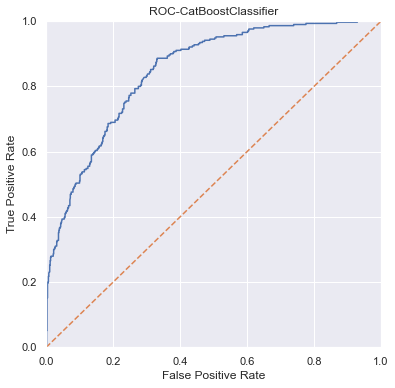

In [58]:
plot_ROC(y_valid, y_pred, 'CatBoostClassifier')

Результат c параметрами из коробки на тренировочной выборке оказался хуже чем у логистической регрессии. AUC =  0.8472

Попробуем поиск по сетке параметров и сбалансируем классы.

In [59]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6716108452950558, 1: 1.9567843866171004}

In [60]:
param_grid = {
     'learning_rate': [0.05, 0.1],
     'depth': [2,3,4],
     'l2_leaf_reg': [3,5,6]
}

In [61]:
%%time
cat_model = CatBoostClassifier(class_weights = class_weights, cat_features=cat_features, random_seed=42, \
                              eval_metric='AUC:hints=skip_train~false', loss_function='Logloss', verbose=200)
 
grid_search_result = cat_model.grid_search(param_grid, X=X_train, y=y_train, plot=False, cv = 5, \
                                           stratified = True, refit=True)


0:	learn: 0.7897089	test: 0.7665325	best: 0.7665325 (0)	total: 11.1ms	remaining: 11.1s
200:	learn: 0.8647544	test: 0.8464044	best: 0.8464044 (200)	total: 2.03s	remaining: 8.09s
400:	learn: 0.8727574	test: 0.8461249	best: 0.8471086 (301)	total: 4s	remaining: 5.97s
600:	learn: 0.8776401	test: 0.8460765	best: 0.8471086 (301)	total: 6.09s	remaining: 4.05s
800:	learn: 0.8819006	test: 0.8461584	best: 0.8471086 (301)	total: 8.1s	remaining: 2.01s
999:	learn: 0.8853345	test: 0.8458827	best: 0.8471086 (301)	total: 10.1s	remaining: 0us

bestTest = 0.8471085774
bestIteration = 301

0:	loss: 0.8471086	best: 0.8471086 (0)	total: 10.1s	remaining: 2m 52s
0:	learn: 0.7897089	test: 0.7665325	best: 0.7665325 (0)	total: 8.72ms	remaining: 8.71s
200:	learn: 0.8719995	test: 0.8481705	best: 0.8485468 (123)	total: 1.95s	remaining: 7.74s
400:	learn: 0.8817001	test: 0.8477755	best: 0.8485468 (123)	total: 3.91s	remaining: 5.85s
600:	learn: 0.8887729	test: 0.8453834	best: 0.8485468 (123)	total: 5.88s	remaining: 3.

999:	learn: 0.9367282	test: 0.8420635	best: 0.8472278 (315)	total: 21.4s	remaining: 0us

bestTest = 0.8472278113
bestIteration = 315

12:	loss: 0.8472278	best: 0.8500037 (9)	total: 2m 59s	remaining: 1m 9s
0:	learn: 0.8084679	test: 0.7824838	best: 0.7824838 (0)	total: 26.8ms	remaining: 26.7s
200:	learn: 0.9009520	test: 0.8441277	best: 0.8472576 (77)	total: 4.46s	remaining: 17.7s
400:	learn: 0.9273268	test: 0.8423616	best: 0.8472576 (77)	total: 8.86s	remaining: 13.2s
600:	learn: 0.9428989	test: 0.8386653	best: 0.8472576 (77)	total: 13.4s	remaining: 8.9s
800:	learn: 0.9555286	test: 0.8322118	best: 0.8472576 (77)	total: 17.7s	remaining: 4.4s
999:	learn: 0.9645696	test: 0.8302072	best: 0.8472576 (77)	total: 21.9s	remaining: 0us

bestTest = 0.8472576198
bestIteration = 77

13:	loss: 0.8472576	best: 0.8500037 (9)	total: 3m 21s	remaining: 57.6s
0:	learn: 0.8083638	test: 0.7824838	best: 0.7824838 (0)	total: 19.1ms	remaining: 19s
200:	learn: 0.8782387	test: 0.8464155	best: 0.8467621 (124)	total:

In [62]:
print(grid_search_result['params'])

{'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


In [63]:
# фиксируем лучший результат по auc на kaggle
cat_best_params = {'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [64]:
cat_model = CatBoostClassifier(class_weights=class_weights, cat_features=cat_features, \
                              random_seed=42, **cat_best_params, silent= True, eval_metric='AUC:hints=skip_train~false')

In [65]:
cat_model.fit(
   X_train, y_train,
   cat_features=cat_features,
   eval_set=(X_valid, y_valid),
   use_best_model=True,
   logging_level='Silent',
   plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
y_pred = cat_model.predict_proba(X_valid)[:, 1]
y_bin = (y_pred >= 0.5)*1

In [67]:
auc = roc_auc_score(y_valid, y_pred)
print("AUC:", auc)
print("")
print(classification_report(y_valid, y_bin))

AUC: 0.8490396348352691

              precision    recall  f1-score   support

           0       0.91      0.70      0.80       763
           1       0.52      0.83      0.63       290

    accuracy                           0.74      1053
   macro avg       0.71      0.77      0.72      1053
weighted avg       0.80      0.74      0.75      1053



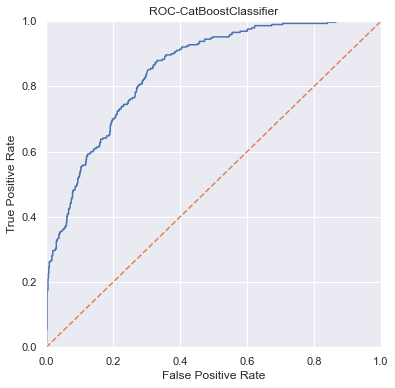

In [68]:
plot_ROC(y_valid, y_pred, 'CatBoostClassifier')

##### Важность признаков

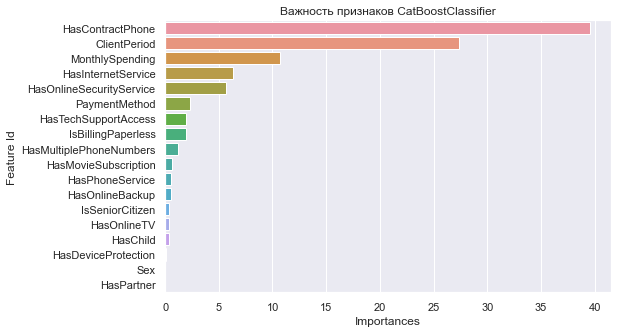

In [69]:
fi = cat_model.get_feature_importance(prettified=True)

plt.figure(figsize=(8, 5));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('Важность признаков CatBoostClassifier');

Важность топ 5 признаков совпадает с важностью признаков оцененной в ходе EDA.

Запишем посылку для
соревнования на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) 

In [70]:
#test = pd.read_csv('./test.csv')
X_test = test.copy()
if 'TotalSpent' in X_test.columns:
    del X_test['TotalSpent']

submission = pd.read_csv('./submission.csv')
submission['Churn'] = cat_model.predict_proba(X_test)[:, 1] 
submission.to_csv('./my_submission_CatBoostClassifier.csv', index=False)

In [71]:
# добавляем данные по модели
result_list.append({ 'Model':'CatBoostClassifier','roc_auc_score':round(auc,5),'kaggle auc':float('0.85351')}) 
result_list    

[{'Model': 'LogisticRegression',
  'roc_auc_score': 0.84864,
  'kaggle auc': 0.84469},
 {'Model': 'CatBoostClassifier',
  'roc_auc_score': 0.84904,
  'kaggle auc': 0.85351}]

**Вывод** Для CatBoostClassifier удалось достичь качества метрики на трайн выборке ROC_AUC = 0.84904

**kaggle AUC = 0.85351**

### LGBMClassifier

Посмотрим ещё одну модель градиентного бустинга LGBMClassifier. Эта модель не требует предобработки категориальных признаков.

In [72]:
df_train = df_train_irq15.copy() #train.copy()

if 'TotalSpent' in df_train.columns:
    del df_train['TotalSpent']
    num_cols = ['ClientPeriod', 'MonthlySpending']
    
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [74]:
%%time
lg = lgb.LGBMClassifier(silent=True, class_weight = 'balanced')

param_list = {"max_depth": [1, 2, 3],
               "num_leaves":[2, 4, 6],
               "learning_rate" : [0.05,0.1],
               "boosting_type": ['gbdt'],
               "n_estimators": [90,100,120],
               "reg_lambda" : [1,5,10]
}                        

my_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)              
            
grid_search = GridSearchCV(lg, n_jobs = -1, param_grid = param_list, cv = my_cv, \
                           scoring = "roc_auc", verbose = 5)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Wall time: 54.8 s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000023180DD5270>,
             estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.05, 0.1], 'max_depth': [1, 2, 3],
                         'n_estimators': [90, 100, 120],
                         'num_leaves': [2, 4, 6], 'reg_lambda': [1, 5, 10]},
             scoring='roc_auc', verbose=5)

In [75]:
best_params_lgb = grid_search.best_params_

In [76]:
best_params_lgb

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 100,
 'num_leaves': 4,
 'reg_lambda': 5}

In [77]:
lgb_model = lgb.LGBMClassifier(**best_params_lgb, silent=True, class_weight = 'balanced', random_state=42)

lgb_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose = False)

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(class_weight='balanced', max_depth=2, num_leaves=4,
               random_state=42, reg_lambda=5)

In [78]:
y_pred = lgb_model.predict_proba(X_valid)[:, 1]
y_bin = (y_pred >= 0.5)*1

In [79]:
auc = roc_auc_score(y_valid, y_pred)
print("AUC:", auc)
print("")
print(classification_report(y_valid, y_bin))

AUC: 0.8523274732227595

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       763
           1       0.51      0.84      0.63       290

    accuracy                           0.73      1053
   macro avg       0.71      0.77      0.71      1053
weighted avg       0.81      0.73      0.75      1053



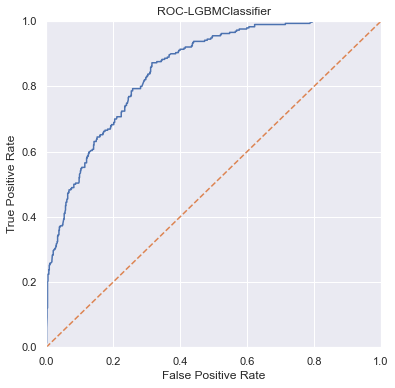

In [80]:
plot_ROC(y_valid, y_pred, 'LGBMClassifier')

#### Важность признаков LGBMClassifier

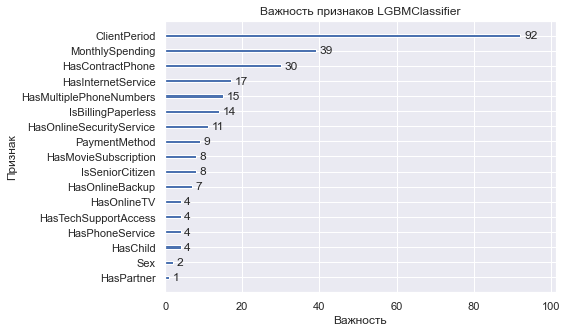

In [81]:
ax0 = lgb.plot_importance(lgb_model, color='b', title='Важность признаков LGBMClassifier', xlabel='Важность', \
                          ylabel='Признак', figsize=(7,5))

Важность топ 5 признаков совпадает с важностью оцененной в ходе EDA. Но по сравнению c catboost более важным стал признак ClientPeriod. 

Запишем посылку для
соревнования на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) 

In [82]:
#test = pd.read_csv('./test.csv')
X_test = test.copy()
if 'TotalSpent' in X_test.columns:
    del X_test['TotalSpent']

submission = pd.read_csv('./submission.csv')
submission['Churn'] = lgb_model.predict_proba(X_test)[:, 1] 
submission.to_csv('./my_submission_LGBMClassifier.csv', index=False)

In [83]:
# добавляем данные по модели
result_list.append({ 'Model':'LGBMClassifier','roc_auc_score':round(auc,5),'kaggle auc':float('0.84928')})    

**Вывод** Для LGBMClassifier удалось достичь качества метрики на трайн выборке ROC_AUC = 0.8523

**kaggle AUC = 0.84928**

In [84]:
# соберем итоговую табличку
result = pd.DataFrame(result_list)
result = result.sort_values(by=['kaggle auc'], ascending = False).reset_index().drop('index', axis=1)
;

''

## Выводы

Для прогнозированния оттока клиентов было проведено исследование EDA. Исследование показало:

Не влияют на отток следующие признаки:
- Sex, HasMultiplePhoneNumbers, HasOnlineTV, HasMovieSubscription

Влияют на отток:
- MonthlySpending (чем больше платежи, тем больше отток)
- ClientPeriod (больший отток в первые периоды)
- PaymentMethod (видим отток при значении Electronic check)
- HasContractPhone (видим отток при значении Month-to-month )
- HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasOnlineSecurityService, HasInternetService, HasInternetService (видим отток при неподключении сервиса, значение - No)

В дальнейшем важность признаков по EDA была подтверждена при помощи feature_importance бустинговыми моделями.

Были построены три модели машинного обучения: линейная - LogisticRegression, и две бустинговых LGBMClassifier и CatBoostClassifier. Результат обучения и тестирования на kaggle сведен в итоговую таблицу.

In [85]:
result

,Model,roc_auc_score,kaggle auc
0,CatBoostClassifier,0.84904,0.85351
1,LGBMClassifier,0.85233,0.84928
2,LogisticRegression,0.84864,0.84469


Лучшие резултаты показал бустинг **CatBoostClassifier** с метрикой на kaggle **AUC = 0.85351**

# Предсказания

In [86]:
best_model = cat_model

In [87]:
#test = pd.read_csv('./test.csv')
X_test = test.copy()
if 'TotalSpent' in X_test.columns:
    del X_test['TotalSpent']

submission = pd.read_csv('./submission.csv')
submission['Churn'] = cat_model.predict_proba(X_test)[:, 1] 
submission.to_csv('./my_submission_CatBoostClassifier.csv', index=False)

Team name Andrey_Bondarchuk

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.